# Non Linear Fine Structure Determination
In this notebook, a non-linear fitting procedure is shown. In particular, the peak energies of the fine structure of the titanium L edge are determined via fitting the appropriate model to the data. The data is not a real sample but **simulated** and shows how to get relevant information on the fitted model via the use of pyEELSMODEL. \
Note that pyEELSMODEL can be used to perform non-linear fitting procedures on EELS data, but it is not optimized for these tasks as we focussed mainly on elemental quantification using linear models. 

In [1]:
%matplotlib qt 
#important for the em.MultiSpectrumVisualizer since this is an interactive plotting tool

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyEELSMODEL.api as em
from pyEELSMODEL.components.linear_background import LinearBG #how to import a class, check documentation of available components
from pyEELSMODEL.components.lorentzian import Lorentzian #how to import a class, check documentation of available components

## Simulation
The EEL spectrum of the titanium L edge is simulated as the linear combination of four lorentzian peaks (amplitude, center and broadening), the atomic cross section and a background function. \
The amplitudes and broading will remain constant accross the EELS map but the central position will vary with probe position. \
*This part of the notebook is off lesser importance since it shows how to simulate some arbitrary fine structure.*

In [3]:
def ti_4(specshape, As, cs, fwhms, settings):
    """
    Small function which calculates the titanium l edge where the As (amplitudes),
    cs (centers) and fhwms are given for the lorentzians,
    """
    E0 = settings[0]
    alpha = settings[1]
    beta = settings[2]    
    
    element = 'Ti'
    edge = 'L'
    
    bg = LinearBG(specshape, rlist=np.linspace(1,5,4))

    comp = em.ZezhongCoreLossEdgeCombined(specshape, 0.5, E0, alpha, beta, element, edge)
    value = 1/comp.data.max()
    comp.parameters[0].setvalue(value)
    
    lorentz = []
    for ii in range(len(As)):
        lorentz.append(Lorentzian(specshape, As[ii], cs[ii], fwhms[ii]))
    
    components = [bg, comp] + lorentz
    mod = em.Model(specshape, components)
    mod.calculate()
    return mod

In [4]:
def change_params(mod, As, cs, fwhms):
    """
    Function which modifies the parameters of the lorentzian peaks
    """
    #first two components are the background and atomic edge
    for ii, comp in enumerate(mod.components[2:]):
        comp.parameters[0].setvalue(As[ii])
        comp.parameters[1].setvalue(cs[ii])
        comp.parameters[2].setvalue(fwhms[ii])
    return mod
    

In [5]:
xsize = 50
ysize = 50 

msh = em.MultiSpectrumshape(0.1, 420, 1024, xsize, ysize)
specshape = msh.getspectrumshape()
settings = (300e3, 1e-9, 20e-3)


As = [4,6,4,6]
fwhms = [0.5,0.8,1,1.3]

#the EELS map has two region of constant fine structure
#only the 
cs1 = [456, 459, 462, 464] 
cs2 = [457, 459, 462.5, 464]

Two different fine structures with different energies of the first and third peak. 

In [6]:
mod1 = ti_4(specshape, As, cs1, fwhms, settings)
mod2 = ti_4(specshape, As, cs2, fwhms, settings)

In [7]:
fig, ax = plt.subplots()
ax.plot(mod1.energy_axis, mod1.data)
ax.plot(mod2.energy_axis, mod2.data)

EEL map will be simulated with constant amplitudes and broadening at each probe position. The center energy of the first and third peak does vary in the map. The first 10 rows all have the same fine structure (*mod1*), the last 10 rows also have the same fine structure (*mod2*). In between, the energy of the first and third peak scales linearly per row. 

In [8]:
scan_size = (xsize, ysize)
As_map = np.ones(scan_size+(4,))
fwhms_map = np.ones(scan_size+(4,))
cs_map = np.ones(scan_size+(4,))

start=10
end=40

XX, YY = np.meshgrid(np.arange(xsize)-start, np.arange(ysize)-start)
m1 = (cs2[0]-cs1[0])/(end-start)
m1 = (cs2[0]-cs1[0])/(end-start)

for ii in range(len(As)):
    As_map[:,:,ii] = As[ii]
    fwhms_map[:,:,ii] = fwhms[ii]
    cs_map[:start,:,ii] = cs1[ii]
    cs_map[end:,:,ii] = cs2[ii]
    
    m = (cs2[ii] - cs1[ii])/(end-start)
    cs_map[start:end,:,ii] = m*YY[start:end,:]+cs1[ii]

In [9]:
fig, ax = plt.subplots(1,4)
for ii in range(cs_map.shape[-1]):
    ax[ii].imshow(cs_map[:,:,ii])
    name = 'Center peak '+str(ii+1)
    ax[ii].set_title(name)


Simulation of the EELS map where at each probe position. It uses the *As_map*, *cs_map*, *fwhms_map* information is input for each lorentzian. There is no thickness effect added to the simulation since this is only for illustration purposes. Noise is added in the form of poisson noise and can be modified using the *cte* value.

In [10]:
cte = 1e2 #counts which modifies the poisson noise 
eels_data = np.zeros((xsize, ysize, msh.Esize))
for index in np.ndindex(scan_size):
        islice = np.s_[index]
        mod = change_params(mod1, As_map[islice], cs_map[islice], fwhms_map[islice])
        
        mod.calculate()
        eels_data[islice] = np.random.poisson(mod.data*cte)

s = em.MultiSpectrum(msh, data=eels_data)

In [11]:
em.MultiSpectrumVisualizer([s])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Visulization of the EEL spectra accross the x direction. This shows how the peak position of the first and third peak changes along the EELS map.

In [12]:
fig, ax = plt.subplots()
ax.imshow(s.multidata.mean(1), aspect='auto')

## Background removal
We will remove the background before the edge since the non-linear fitting procedure can become unstable when adding the background component to the model. However, if it works in your particular case, then  you can add the background to the model itself. Note that the simulated background is the sum of powerlaws, this means that a small bias could arise due to the power-law background removal. This bias also occurs in experimental data since we do not have knowledge on the exact shape of the background. 

In [13]:
back = em.BackgroundRemoval(s, (425,440))
rem = back.calculate_multi()

True


2500it [00:00, 8007.64it/s]
2500it [00:04, 563.01it/s]
2500it [00:00, 22990.50it/s]


## Non-linear fittings
The model used for the fitting will be created as the sum of four lorentzians and one atomic cross section. 

In [14]:
#the experimental settings
specshape = s.get_spectrumshape()
E0 = settings[0]
alpha = settings[1]
beta = settings[2]    

element = 'Ti'
edge = 'L'

An average spectrum is created from the first row to have some estimate of starting parameters and the boundaries. 

In [15]:
smean = rem[0,:].mean()

In [16]:
smean.plot()

As, cs and fwhms are set manually from the average spectrum. 

In [17]:
As = [500,500,500,500]
cs = [456, 459,462,464]
fwhms = [1,1,1,1]
lorentz = []
for ii in range(len(As)):
    lorentz.append(Lorentzian(specshape, As[ii], cs[ii], fwhms[ii]))

Also boundaries will be set for each lorentz. This is subject to user interpretation of the data. In this case, the amplitude boundaries are between 100 and 2000. The center of each peak has boundaries -1.5 to 1.5 eV with respect to the inputted *cs*. The broadening cannot lower than 0.2 and bigger than 3 eV. Some iterative steps can be used to find the suitable boundaries to let the fitter convergence to the right solution. 

In [18]:
for lor in lorentz:
    lor.parameters[0].setboundaries(100,2000)
    
    val = lor.parameters[1].getvalue()
    lor.parameters[1].setboundaries(val-1.5, val+1.5)

    lor.parameters[2].setboundaries(0.2, 3)

In [19]:
#the atomic cross section
comp = em.ZezhongCoreLossEdgeCombined(specshape, 1, E0, alpha, beta, element, edge)

In [20]:
components = [comp] + lorentz
mod = em.Model(specshape, components)
mod.calculate()

Shows the calculated model with the parameters values set in the previous cells. This should be more or less similar to the expected fit. 

In [21]:
mod.plot(spectrum=smean)

Some energy bins can be excluded from the fit. In this case, the background region before the edge will be excluded and not used in the fit. 

In [22]:
smean.set_exclude_region_energy(0, 455)
smean.show_excluded_region()

The fit on *smean* gives a better estimate of the starting parameters which can be used in the fit of the multispectrum. 
After the fit is performed, the fitted parameters are set as values for the model (*mod*). This model can then again be used for the fit of the multispectrum since the new starting guess is closer to the optimum. The [least-squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) from scipy is used to perform the fitting. See documentation for more information. 

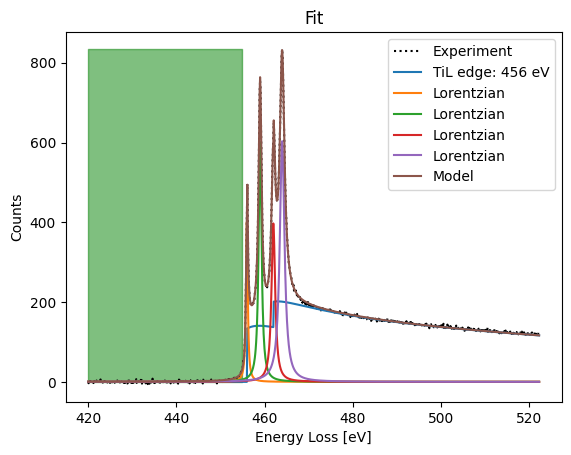

In [23]:
fit = em.LSQFitter(smean, mod, use_bounds=True, method='trf')
fit.perform_fit()        
fit.plot()        

In [24]:
#removing some energy region from the fit
rem.set_exclude_region_energy(0, 455)
rem.show_excluded_region() #check which regions are excluded from the fit

In [25]:
fitm = em.LSQFitter(rem, mod, use_bounds=True, method='trf')
fitm.multi_fit()

2500it [00:42, 58.92it/s]


In [26]:
multimodel=fitm.model_to_multispectrum()

2500it [00:00, 14001.21it/s]


In [27]:
#visualization of the resulting fit
em.MultiSpectrumVisualizer([rem, multimodel])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


### Comparison with ground truth
The last part shows how to interact with the resulting fits and how one can use matplotlib to visualize the results. The *fitm.get_map(parameter)* function needs as input a parameter and will return the map of the parameter. If this paramter is not optimized in the fit then it will return None.

In [33]:
# The average value of the amplitude of different lorentzians compared to the ground truth
fig, ax = plt.subplots(1,4)
xaxis = np.arange(xsize)
for ii, lor in enumerate(lorentz):
    mp = fitm.get_map(lor.parameters[0])
    ax[ii].errorbar(xaxis, mp.mean(1), yerr=mp.std(1), capsize=5)
    ax[ii].plot(xaxis, cte*As_map[:,:,ii].mean(1), color='black') #cte to input the real amplitude value 

In [35]:
# The average value of the center of different lorentzians compared to the ground truth
fig, ax = plt.subplots(1,4)
xaxis = np.arange(xsize)
for ii, lor in enumerate(lorentz):
    mp = fitm.get_map(lor.parameters[1])
    ax[ii].errorbar(xaxis, mp.mean(1), yerr=mp.std(1), capsize=5)
    ax[ii].plot(xaxis, cs_map[:,:,ii].mean(1), color='black')

In [37]:
fig, ax = plt.subplots(1,4)
xaxis = np.arange(xsize)
for ii, lor in enumerate(lorentz):
    mp = fitm.get_map(lor.parameters[2])
    ax[ii].errorbar(xaxis, mp.mean(1), yerr=mp.std(1), capsize=5)
    ax[ii].plot(xaxis, fwhms_map[:,:,ii].mean(1), color='black')

In [39]:
#2d maps of the center energy 
fig, ax = plt.subplots(1,4)
for ii, lor in enumerate(lorentz):
    mp = fitm.get_map(lor.parameters[1])
    ax[ii].imshow(mp)
